<h1><center>Deep Unsupervised Learning<center></h1>
<center>By Valeria Bega, Theresa Wohlsen and Francesco Donato</center>


### Table of Contents

* [1. Input](#chapter1)
* [2. Semi-Supervised VAE (M1)](#chapter2)
* [3. Classifier for m1](#chapter3)



In [2]:
#imports

from collections import  defaultdict
from functools import reduce
from IPython.display import Image, display, clear_output
import itertools
from itertools import cycle
import matplotlib.pyplot as plt
%matplotlib nbagg
%matplotlib inline
import numpy as np
import pandas as pd
from plotting import make_vae_plots
from scipy.stats import norm
import seaborn as sns
sns.set_style("whitegrid")
# from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, PredefinedSplit, StratifiedShuffleSplit #extraction of balanced labelled data, maybe can create custom one
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sys
sys.path.append('../')
import torch
from torch.distributions import Bernoulli, Normal, Categorical, kl_divergence, Distribution
import torch.nn as nn
from torch import nn, Tensor
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1.Input** <a class="anchor" id="chapter1"></a>
We will first prepare the data. We will use what is known as binarized MNIST where all the pixels
take binary values, i.e. they are either 0 or 1.
1. Set up a script using the MNIST Dataset from torchvision.
2. Plot 64 randomly chosen samples on a 8 × 8 grid.
3. Using the transform argument, implement dynamic binarization, where the binarized {0, 1}
pixels are sampled using the pixel intensity as the probability.
4. (Report) Plot 64 randomly chosen binarized MNIST samples on a 8 × 8 grid.

In [5]:
## Dataset Load
def uniform_stratified_sampler(labels, classes, n=None):
    """
    Stratified sampler that distributes labels uniformly by
    sampling at most n data points per class
    """
    from functools import reduce
    # Only choose digits in n_labels
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))

    # Ensure uniform distribution of labels
    np.random.shuffle(indices)
    indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in classes])

    indices = torch.from_numpy(indices)
    sampler = SubsetRandomSampler(indices)
    return sampler    

flatten = Lambda(lambda x: ToTensor()(x).view(28**2))
binarize = Lambda(lambda x: torch.bernoulli(x))

transform = Compose(
    [flatten,
     binarize
    ]
)

# Load dataset base MNIST
trainset_base = MNIST("./", train=True, download=True, transform=flatten)

# Load dataset binarized MNIST
trainset = MNIST("./", train=True, download=True, transform=transform)
testset = MNIST("./", train=False, download=True, transform=transform)



# batch size 64 for visualization, or create a function that takes 64 samples with different batch sizes
train_loader_base = torch.utils.data.DataLoader(trainset_base, batch_size=64,
                                           num_workers=2,shuffle=True)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                           num_workers=2,shuffle=True)

test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                           num_workers=2,shuffle=True)


# Semisupervise M2
classes = [0,1,2,3,4,5,6,7,8,9]
labels_per_class = 100 #results with 10 are recorded
uniform_sampler = uniform_stratified_sampler(trainset.targets, classes=classes, n=labels_per_class)
labelled_indices = uniform_sampler.indices.numpy().tolist()
unlabelled_indices = list(set(range(len(trainset))) - set(labelled_indices))
unlabelled_subset = torch.utils.data.Subset(trainset,unlabelled_indices)

# Smaller pool of labelled data
labelled = DataLoader(trainset, batch_size=64, sampler=uniform_sampler)
unlabelled = DataLoader(unlabelled_subset, batch_size=64, shuffle=True)

val_loader = test_loader # for model version 2
val_data = testset  # for model version 2

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
#Number of samples
print(len(trainset))

60000


In [7]:
#Number of samples
print(len(testset))

10000


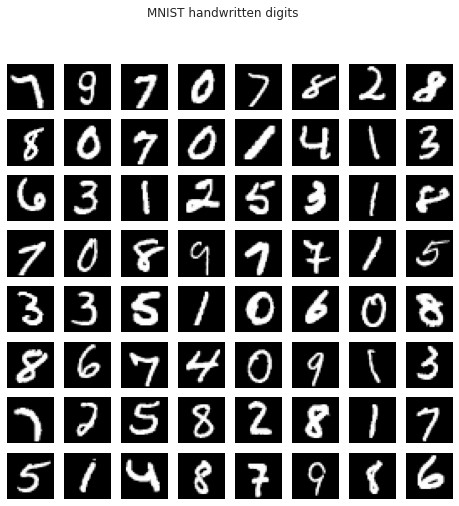

In [8]:
#plot a few MNIST examples
# Load a batch of images into memory (train_loader_base for basic MNIST)
images, labels = next(iter(train_loader_base))

fig, axs = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i].view(28, 28), cmap='Greys_r')
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

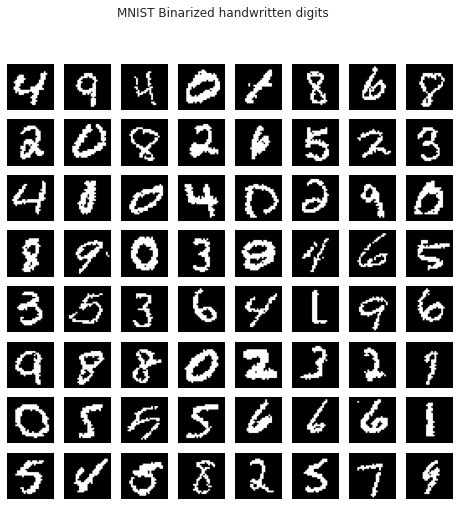

In [9]:
#plot a few Binarized MNIST examples

# Load a batch of images into memory (train_loader for Binarized MNIST)
images, labels = next(iter(train_loader))

fig, axs = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i].view(28, 28), cmap='Greys_r')
    ax.axis('off')

plt.suptitle('MNIST Binarized handwritten digits')
plt.show()

In [10]:
print(len(train_loader))

938


# **2.VAE** <a class="anchor" id="chapter2"></a>

Implement a VAE as a torch.nn.Module.
1. Implement a method .encode(...) that encodes a batch of x.
2. Implement a method .decode(...) that decodes a batch of z.
3. Implement a method .sample(...) that generates samples.
4. Implement a method .elbo(...) that computes the ELBO.

## Parameters

In [11]:
# model parameters
NUM_PIXELS = 784 # 52x52
NUM_SHAPE = images[0].shape
NUM_HIDDEN1 = 512
NUM_HIDDEN2 = 256
LATENT_FEATURES = 10 # change number of latent features
NUM_DIGITS = 10
NUM_STYLE = 50   

# training parameters
NUM_SAMPLES = 10 #100 
NUM_BATCH = 128
NUM_EPOCHS = 200 #200 #100 #1000
LABEL_FRACTION = 0.1
LEARNING_RATE = 1e-3
BETA = 0.90
EPS = 1e-9
INIT_METHOD = "Xavier" #"Kaiming-He"
ACTIVATION = "ReLU" #"LeakyReLU" #"Softplus"
#CUDA = torch.cuda.is_available()
CUDA = True

## Implement a VAE

In [12]:
# Weight initialization function
def init_weights(net, init_method=INIT_METHOD):
    if type(net)== nn.Linear:
        if init_method == "Xavier":
            torch.nn.init.xavier_uniform_(net.weight)
            net.bias.data.fill_(0.)
        elif init_method == "Kaiming-He":
            torch.nn.init.kaiming_uniform_(net.weight)
            net.bias.data.fill_(0.)

In [13]:
def activation_function(activation=ACTIVATION):
    if activation == "ReLU":
      return nn.ReLU()
    elif activation == "LeakyReLU":
      return nn.LeakyReLU()
    elif activation == "Softplus":
      return nn.Softplus()
    else:
      raise NotImplementedError("Wrong activation function")

In [14]:
class VAE(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """

    #input_shape:torch.Size, latent_features:int
    def __init__(self,
                 num_pixels=NUM_PIXELS, 
                 num_hidden1=NUM_HIDDEN1,
                 num_hidden2=NUM_HIDDEN2,
                 num_digits=NUM_DIGITS,
                 num_style=NUM_STYLE,
                 num_batch=NUM_BATCH,
                 num_shape=NUM_SHAPE,
                 latent_features=LATENT_FEATURES,
                 activation = ACTIVATION,
                 batchnorm = False,
                 dropout:float = None) -> None:
      super(VAE, self).__init__()

      self.num_shape = num_shape
      self.latent_features = latent_features
      self.observation_features = np.prod(num_shape)


      # Inference Network
      # Encode the observation `x` into the parameters of the posterior distribution
      # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
      self.encoder = nn.Sequential(
            nn.Linear(in_features=num_pixels, out_features=num_hidden1),
            activation_function(activation),
            nn.Linear(in_features=num_hidden1, out_features=num_hidden2),
            activation_function(activation),
            nn.Linear(in_features=num_hidden2, out_features=2*latent_features)
            )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
      self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=num_hidden2),
            activation_function(activation),
            nn.Linear(in_features=num_hidden2, out_features=num_hidden1),
            activation_function(activation),
            nn.Linear(in_features=num_hidden1, out_features=self.observation_features)
            )
        
      # define the parameters of the prior, chosen as p(z) = N(0, I)
      self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        

          
    def posterior(self, x:Tensor):
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1):
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor):
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.num_shape) # reshape the output
        return Bernoulli(logits=px_logits)
        

    def forward(self, x):
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


vae = VAE(NUM_PIXELS,
          NUM_HIDDEN1,
          NUM_HIDDEN2,
          NUM_DIGITS,
          NUM_STYLE,
          NUM_BATCH,
          NUM_SHAPE,
          LATENT_FEATURES,
          ACTIVATION)
print(vae)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [15]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma * self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        gaussian = torch.distributions.Normal(self.mu, self.sigma)
        return gaussian.log_prob(z)

In [16]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=BETA):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor):
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ['px', 'pz', 'qz', 'z']]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl 
        beta_elbo = log_px - self.beta * kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [17]:
vi = VariationalInference(BETA)
loss, diagnostics, outputs = vi(vae, images)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =    545.555, shape: []
elbo   | mean =   -545.558, shape: [64]
log_px | mean =   -545.534, shape: [64]
kl     | mean =      0.023, shape: [64]


## Train Model

In [18]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
vae = VAE(NUM_PIXELS,
          NUM_HIDDEN1,
          NUM_HIDDEN2,
          NUM_DIGITS,
          NUM_STYLE,
          NUM_BATCH,
          NUM_SHAPE,
          LATENT_FEATURES,
          ACTIVATION)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

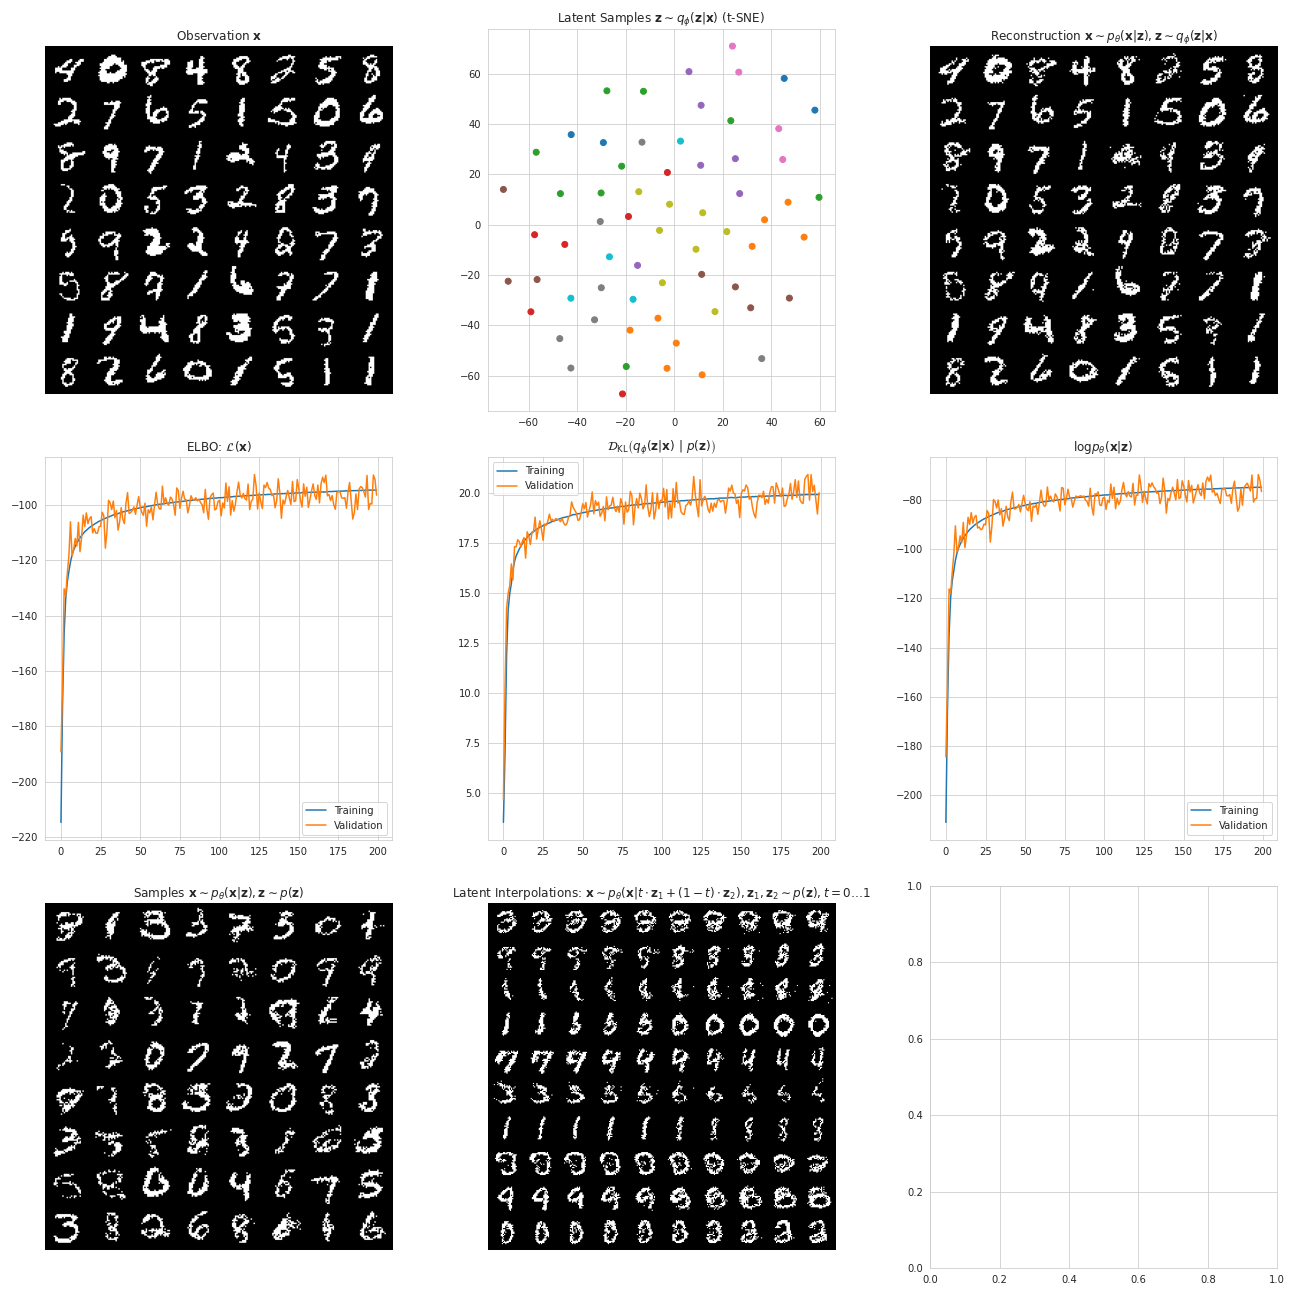

In [19]:
num_epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
  
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    make_vae_plots(vae, x, y, outputs, training_data, validation_data)

# **3. Semi-Supervised VAE (M1)** <a class="anchor" id="chapter4"></a>
We have now trained a VAE on the full unlabeled da
taset. We will now implement the M1 model
from Semi-Supervised Learning with Deep Generative Models. This amounts to simply training
a classifier on top of the representations learned by our VAE.
1. Extract 100 labeled datapoints from MNIST (10 from each class).

## Preparing dataset for classification

In [20]:
classes = [0,1,2,3,4,5,6,7,8,9]
labels_per_class = 10 #results with 100 are recorded

# Smaller pool of labelled data
labelled_all = DataLoader(trainset, batch_size = labels_per_class*len(classes),
                      sampler=uniform_stratified_sampler(trainset.targets, classes=classes, n=labels_per_class))

test_loader_all = torch.utils.data.DataLoader(testset, batch_size=len(testset),shuffle=True)

vae.cpu().eval()

x_train, y_train = next(iter(labelled_all))
x_test, y_test = next(iter(test_loader_all))

In [21]:

_ , _ , outputs = vi(vae, x_train)
z_train = outputs['z']
z_train = z_train.detach().numpy()
y_train = y_train.numpy()

_ , _ , outputs_test = vi(vae, x_test)
z_test = outputs_test['z']
z_test = z_test.detach().numpy()
y_test = y_test.numpy()

In [22]:
print(z_train.shape, z_test.shape)

Z = np.concatenate((z_train,z_test))
Y = np.concatenate((y_train,y_test))

#This is what you need
train_index =[-1]*len(z_train)
test_index =[0]*len(z_test)
test_fold = train_index+test_index
ps = PredefinedSplit(test_fold) #refit=false in case

(100, 10) (10000, 10)


## Linear classification from latent features


#### Linear method from sklearn

In [23]:
# svm_classifier.get_params().keys()
##SVM
C = [0.0001, 0.0005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
svm_param = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': C },
             {'kernel': ['linear'], 'C': C }]

svm_classifier = GridSearchCV(SVC(),
                              svm_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

svm_classifier.fit(Z,Y)
print(svm_classifier.best_params_)
pd.DataFrame(svm_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
26,0.002417,0.0,0.063241,0.0,50,0.001,rbf,"{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}",0.8073,0.8073,0.0,1,0.89,0.89,0.0
38,0.001924,0.0,0.037684,0.0,0.1,NaN,linear,"{'C': 0.1, 'kernel': 'linear'}",0.8071,0.8071,0.0,2,0.88,0.88,0.0
28,0.004887,0.0,0.062340,0.0,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.8012,0.8012,0.0,3,0.94,0.94,0.0
37,0.001804,0.0,0.036307,0.0,0.05,NaN,linear,"{'C': 0.05, 'kernel': 'linear'}",0.7871,0.7871,0.0,4,0.86,0.86,0.0
39,0.002393,0.0,0.031976,0.0,0.5,NaN,linear,"{'C': 0.5, 'kernel': 'linear'}",0.7792,0.7792,0.0,5,0.95,0.95,0.0
40,0.002599,0.0,0.031311,0.0,1,NaN,linear,"{'C': 1, 'kernel': 'linear'}",0.7760,0.7760,0.0,6,0.99,0.99,0.0
44,0.002526,0.0,0.031488,0.0,100,NaN,linear,"{'C': 100, 'kernel': 'linear'}",0.7706,0.7706,0.0,7,1.00,1.00,0.0
42,0.002523,0.0,0.031685,0.0,10,NaN,linear,"{'C': 10, 'kernel': 'linear'}",0.7706,0.7706,0.0,7,1.00,1.00,0.0
41,0.002579,0.0,0.031646,0.0,5,NaN,linear,"{'C': 5, 'kernel': 'linear'}",0.7706,0.7706,0.0,7,1.00,1.00,0.0
43,0.002506,0.0,0.022931,0.0,50,NaN,linear,"{'C': 50, 'kernel': 'linear'}",0.7706,0.7706,0.0,7,1.00,1.00,0.0


In [24]:
svc = SVC(C = svm_classifier.best_params_["C"], kernel=svm_classifier.best_params_["kernel"]).fit(z_train,y_train)
print(accuracy_score(svc.predict(z_test),y_test))
print(classification_report(svc.predict(z_test),y_test))
print(confusion_matrix(svc.predict(z_test),y_test))

0.7959
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       889
           1       0.94      0.91      0.92      1183
           2       0.83      0.68      0.75      1268
           3       0.70      0.85      0.76       830
           4       0.76      0.95      0.84       789
           5       0.79      0.78      0.79       907
           6       0.83      0.90      0.87       888
           7       0.72      0.88      0.79       836
           8       0.82      0.58      0.68      1385
           9       0.73      0.72      0.73      1025

    accuracy                           0.80     10000
   macro avg       0.79      0.81      0.80     10000
weighted avg       0.80      0.80      0.79     10000

[[ 798    2   14   16    3   22   12    5   11    6]
 [   0 1071   32   13    6    4   21   23    6    7]
 [  66   10  858   69   43   29    9  138   24   22]
 [   5    8   52  702    9   27    1    6   14    6]
 [   0    0    0    0 

In [25]:
##Logistic
l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
logistic_param = [{"penalty":["l2"], "C":C},
                  {"penalty":["l1"], "C":C},
                   {"penalty":["elasticnet"], "C":C, "l1_ratio":l1_ratio}]

logistic_classifier = GridSearchCV(LogisticRegression(solver="saga"),
                              logistic_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

logistic_classifier.fit(Z,Y)
print(logistic_classifier.best_params_)
pd.DataFrame(logistic_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'C': 0.5, 'penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_l1_ratio,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
9,0.010382,0.0,0.002050,0.0,0.5,l2,NaN,"{'C': 0.5, 'penalty': 'l2'}",0.7851,0.7851,0.0,1,0.90,0.90,0.0
111,0.012421,0.0,0.001904,0.0,0.5,elasticnet,0.1,"{'C': 0.5, 'l1_ratio': 0.1, 'penalty': 'elasti...",0.7839,0.7839,0.0,2,0.90,0.90,0.0
112,0.011234,0.0,0.002035,0.0,0.5,elasticnet,0.2,"{'C': 0.5, 'l1_ratio': 0.2, 'penalty': 'elasti...",0.7815,0.7815,0.0,3,0.91,0.91,0.0
113,0.012633,0.0,0.001955,0.0,0.5,elasticnet,0.3,"{'C': 0.5, 'l1_ratio': 0.3, 'penalty': 'elasti...",0.7790,0.7790,0.0,4,0.91,0.91,0.0
120,0.016003,0.0,0.002016,0.0,1,elasticnet,0.1,"{'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticn...",0.7778,0.7778,0.0,5,0.94,0.94,0.0
10,0.014163,0.0,0.004439,0.0,1,l2,NaN,"{'C': 1, 'penalty': 'l2'}",0.7772,0.7772,0.0,6,0.93,0.93,0.0
114,0.011434,0.0,0.001970,0.0,0.5,elasticnet,0.4,"{'C': 0.5, 'l1_ratio': 0.4, 'penalty': 'elasti...",0.7769,0.7769,0.0,7,0.91,0.91,0.0
121,0.017383,0.0,0.002123,0.0,1,elasticnet,0.2,"{'C': 1, 'l1_ratio': 0.2, 'penalty': 'elasticn...",0.7758,0.7758,0.0,8,0.94,0.94,0.0
122,0.017422,0.0,0.002096,0.0,1,elasticnet,0.3,"{'C': 1, 'l1_ratio': 0.3, 'penalty': 'elasticn...",0.7749,0.7749,0.0,9,0.94,0.94,0.0
115,0.012871,0.0,0.002059,0.0,0.5,elasticnet,0.5,"{'C': 0.5, 'l1_ratio': 0.5, 'penalty': 'elasti...",0.7733,0.7733,0.0,10,0.92,0.92,0.0


In [26]:
if len(logistic_classifier.best_params_) == 2:
    logistic_regression = LogisticRegression(solver="saga", C = logistic_classifier.best_params_["C"], penalty=logistic_classifier.best_params_["penalty"]).fit(z_train,y_train)#if not elastic net
elif len(logistic_classifier.best_params_) == 3:
    logistic_regression = LogisticRegression(solver="saga", C = logistic_classifier.best_params_["C"], penalty=logistic_classifier.best_params_["penalty"], l1_ratio= logistic_classifier.best_params_["l1_ratio"]).fit(z_train,y_train)#if elastic net
print(accuracy_score(logistic_regression.predict(z_test),y_test))
print(classification_report(logistic_regression.predict(z_test),y_test))
print(confusion_matrix(logistic_regression.predict(z_test),y_test))

0.7852
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       903
           1       0.90      0.91      0.90      1131
           2       0.85      0.71      0.77      1245
           3       0.76      0.82      0.79       932
           4       0.76      0.87      0.81       860
           5       0.74      0.80      0.77       826
           6       0.84      0.89      0.86       899
           7       0.77      0.83      0.80       954
           8       0.76      0.57      0.66      1296
           9       0.65      0.68      0.67       954

    accuracy                           0.79     10000
   macro avg       0.78      0.80      0.79     10000
weighted avg       0.79      0.79      0.78     10000

[[ 785    1   13   14    3   36    9    1   28   13]
 [   0 1024   37    7    9    3   24    7   17    3]
 [  50   70  880   66   24   13   15   83   21   23]
 [   2    8   34  766   16   64    5    6   25    6]
 [   5    1    7    0 

In [27]:
#KNN
KNN_param = {"n_neighbors":list(range(1,30,2))}

KNN_classifier = GridSearchCV(KNeighborsClassifier(),
                              KNN_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

KNN_classifier.fit(Z,Y)
print(KNN_classifier.best_params_)
pd.DataFrame(KNN_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'n_neighbors': 7}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
3,0.000957,0.0,0.481097,0.0,7,{'n_neighbors': 7},0.7079,0.7079,0.0,1,0.78,0.78,0.0
4,0.001035,0.0,0.466719,0.0,9,{'n_neighbors': 9},0.7067,0.7067,0.0,2,0.80,0.80,0.0
2,0.000983,0.0,0.459434,0.0,5,{'n_neighbors': 5},0.7061,0.7061,0.0,3,0.79,0.79,0.0
5,0.000928,0.0,0.469336,0.0,11,{'n_neighbors': 11},0.7009,0.7009,0.0,4,0.82,0.82,0.0
6,0.001032,0.0,0.473080,0.0,13,{'n_neighbors': 13},0.6911,0.6911,0.0,5,0.82,0.82,0.0
1,0.002428,0.0,0.508347,0.0,3,{'n_neighbors': 3},0.6888,0.6888,0.0,6,0.83,0.83,0.0
7,0.001008,0.0,0.480302,0.0,15,{'n_neighbors': 15},0.6829,0.6829,0.0,7,0.80,0.80,0.0
0,0.004738,0.0,0.471977,0.0,1,{'n_neighbors': 1},0.6748,0.6748,0.0,8,1.00,1.00,0.0
8,0.001206,0.0,0.468819,0.0,17,{'n_neighbors': 17},0.6748,0.6748,0.0,8,0.81,0.81,0.0
9,0.001040,0.0,0.488273,0.0,19,{'n_neighbors': 19},0.6658,0.6658,0.0,10,0.77,0.77,0.0


In [28]:
KNN = KNeighborsClassifier(n_neighbors=KNN_classifier.best_params_["n_neighbors"]).fit(z_train,y_train)
print(accuracy_score(KNN.predict(z_test),y_test))
print(classification_report(KNN.predict(z_test),y_test))
print(confusion_matrix(KNN.predict(z_test),y_test))

0.7079
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1022
           1       0.93      0.65      0.76      1626
           2       0.48      0.74      0.58       663
           3       0.81      0.59      0.69      1384
           4       0.69      0.87      0.77       784
           5       0.58      0.82      0.68       630
           6       0.79      0.91      0.84       832
           7       0.67      0.78      0.72       884
           8       0.66      0.59      0.62      1093
           9       0.64      0.60      0.62      1082

    accuracy                           0.71     10000
   macro avg       0.70      0.73      0.71     10000
weighted avg       0.73      0.71      0.71     10000

[[ 784    1   67   24    9   39   49    3   35   11]
 [   2 1051  214   52   20   76   29   95   51   36]
 [  38    2  493   20    8    5   12   69    7    9]
 [  28   46  101  823   52  160   20   16   96   42]
 [   7    1   12    0 

#### Training Neural Network on top of Z

In [29]:
# define network
class FFNN(nn.Module):

    def __init__(self, layers_, num_output_, activation ="ReLU",batchnorm = False, dropout:float = None):
        super().__init__() 
        self.layers = []
        # layer construction
        for i in range(len(layers_)-1):#more than 2 layers
            self.layers.append(nn.Linear(layers_[i], layers_[i+1]))
            if activation == "ReLU":
                self.layers.append(nn.ReLU())
            elif activation == "LeakyReLU":
                self.layers.append(nn.LeakyReLU())
            elif activation == "Softplus":
                self.layers.append(nn.Softplus())
            else:
                raise NotImplementedError("Wrong activation function")
            if batchnorm:
                self.layers.append(nn.BatchNorm1d(layers_[i+1]))
            if dropout:
                self.layers.append(nn.Dropout(dropout))

        # output layer
        self.layers.append(nn.Linear(layers_[-1], num_output_))

        #finalize net
        self.layers = nn.Sequential(*self.layers)
        

    def forward(self, x):
        return self.layers(x)

In [30]:
# ## CHOOSE AND LOAD MODEL
# vae = torch.load("/content/drive/MyDrive/Deep Learning/Deep Learning Final Project/torch_model/Beta_VAE_200")

vae.cuda().eval()

labelled_loader = DataLoader(trainset, batch_size=25,sampler=uniform_stratified_sampler(trainset.targets, classes=classes, n=labels_per_class))

class Classifier_latentspace_M2(FFNN):
    def __init__(self,layers,num_classes):
        super().__init__(layers,num_classes)        

    def forward(self, x):
        x = self.layers(x)
        return F.log_softmax(x, dim=1)

layer_classifier = [10,128,60]
num_classes = 100
net_classifier = Classifier_latentspace_M2(layer_classifier, num_classes)
init_weights(net_classifier)
net_classifier.cuda()

Classifier_latentspace_M2(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=100, bias=True)
  )
)

In [31]:
## net training-evaluation
criterion = nn.CrossEntropyLoss()  # Your code here!
optimizer = torch.optim.Adam(net_classifier.parameters(), lr=0.001)  # Momentum ruins the learning of my model

num_epoch = 200  # Your code here!
train_acc = []
val_acc = []
diff_acc=[100.]
for epoch in range(num_epoch):  # loop over the dataset multiple times
    net_classifier.train()
    running_loss = 0.0
    losses = []
    for i, data in enumerate(labelled_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = inputs.cuda(),labels.cuda()
        inputs = vae(inputs)['z']
        inputs.detach().cuda()

        optimizer.zero_grad()
        output = net_classifier(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
    
    losses.append(running_loss / i)
    
    ### Evaluate validation
    net_classifier.eval()
    correct_v = 0
    total_v = 0
    for i_v, data_v in enumerate(test_loader, 0):
         
        # get the inputs
        inputs_v, labels_v = data_v

        # wrap them in Variable
        inputs_v, labels_v = inputs_v.cuda(), labels_v.cuda()
        inputs_v = vae(inputs_v)['z']
        inputs_v.detach().cuda()
        
        output_v = net_classifier(inputs_v)
        _, predicted_v = torch.max(output_v.data, 1)
        total_v += labels_v.size(0)
        correct_v += (predicted_v == labels_v).sum()

    val_acc.append(100 * correct_v.true_divide(total_v))

    # early stopping
    if len(val_acc)>=2:
        diff_acc.append(np.round(val_acc[-1].cpu() - val_acc[-2].cpu(),4))
        
        
    
    print("Epoch %2i : Train Loss %f , Valid acc %f, Rounded incremental learning %f" % (
        epoch+1, losses[-1], val_acc[-1],diff_acc[-1]))
    
    #if for 3 consecutive step the result is worse or doesn't improve enough stop
    try:
        if diff_acc[-1]<0.001 & diff_acc[-2]<0.001 & diff_acc[-3]<0.001:
            print("Early stopping reached")
            break
    except: pass
   

print('Finished Training')

Epoch  1 : Train Loss 6.065379 , Valid acc 14.209999, Rounded incremental learning 100.000000
Epoch  2 : Train Loss 5.864576 , Valid acc 18.730000, Rounded incremental learning 4.520000
Epoch  3 : Train Loss 5.655916 , Valid acc 19.639999, Rounded incremental learning 0.910000
Epoch  4 : Train Loss 5.383039 , Valid acc 19.879999, Rounded incremental learning 0.240000
Epoch  5 : Train Loss 5.025037 , Valid acc 18.309999, Rounded incremental learning -1.570000
Epoch  6 : Train Loss 4.603447 , Valid acc 17.369999, Rounded incremental learning -0.940000
Epoch  7 : Train Loss 4.113142 , Valid acc 16.020000, Rounded incremental learning -1.350000
Epoch  8 : Train Loss 3.629390 , Valid acc 16.430000, Rounded incremental learning 0.410000
Epoch  9 : Train Loss 3.198390 , Valid acc 19.779999, Rounded incremental learning 3.350000
Epoch 10 : Train Loss 2.895429 , Valid acc 30.080000, Rounded incremental learning 10.300000
Epoch 11 : Train Loss 2.623274 , Valid acc 42.969997, Rounded incremental 

In [32]:
vae.eval().cuda()
net_classifier.eval().cuda()

x_test, y_test = next(iter(test_loader_all))


z_test_class = vae(x_test.cuda())['z']
z_test_class  =  z_test_class.detach()
output_clasifier = net_classifier(z_test_class)
_, y_predict = torch.max(output_clasifier.data, 1)

y_predict = y_predict.detach().cpu().numpy()
y_test = y_test.numpy()


print(accuracy_score(y_predict,y_test))
print(classification_report(y_predict,y_test))
print(confusion_matrix(y_predict,y_test))

0.8067
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       993
           1       0.93      0.92      0.93      1144
           2       0.75      0.84      0.80       924
           3       0.78      0.72      0.75      1100
           4       0.84      0.77      0.80      1066
           5       0.62      0.78      0.69       713
           6       0.89      0.92      0.90       920
           7       0.82      0.78      0.80      1082
           8       0.75      0.76      0.75       956
           9       0.73      0.67      0.70      1102

    accuracy                           0.81     10000
   macro avg       0.80      0.81      0.80     10000
weighted avg       0.81      0.81      0.81     10000

[[ 904    0   16    6    1   26   25    0   10    5]
 [   0 1055   24    4   15   11    3   18    1   13]
 [   6   43  779   47    1    1    8   23   12    4]
 [  12    8   92  790    5   99    0    5   77   12]
 [  11   12   15    0 

Confusion matrix, without normalization
[[ 904    0    6   12   11    1   12   14    5   15]
 [   0 1055   43    8   12    0    2    3    9    3]
 [  16   24  779   92   15    0   16   73   11    6]
 [   6    4   47  790    0  100    0   13   49    1]
 [   1   15    1    5  824    0   10   12    5  109]
 [  26   11    1   99   10  555   26   24  109   31]
 [  25    3    8    0   24   25  849    8   12    4]
 [   0   18   23    5   13    1    0  844    0  124]
 [  10    1   12   77   40   21    5   14  726   68]
 [   5   13    4   12  117   10    0   77   30  741]]




"# Plot normalized confusion matrix\nplt.figure()\nplt.grid(False)\nplot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,\n                      title='Normalized confusion matrix')\n\nplt.show()"

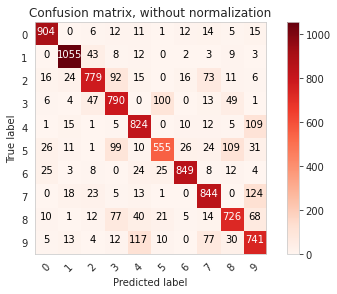

In [33]:
# Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
   
    print(cm)
    print("\n")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #tick_marks = np.arange(0)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    fmt = '.2f' if normalize else 'd'


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

"""# Plot normalized confusion matrix
plt.figure()
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()"""

## Linear Classification from raw data



#### Linear method from sklearn

In [34]:
X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))

#This is what you need
train_index =[-1]*len(x_train)
test_index =[0]*len(x_test)
test_fold = train_index+test_index
ps = PredefinedSplit(test_fold) #refit=false in case

In [35]:
# svm_classifier.get_params().keys()
##SVM
C = [0.0001, 0.0005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
svm_param = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': C },
             {'kernel': ['linear'], 'C': C }]

svm_classifier = GridSearchCV(SVC(),
                              svm_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)
svm_classifier.fit(X,Y)
print(svm_classifier.best_params_)
pd.DataFrame(svm_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
28,0.035066,0.0,1.132298,0.0,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.7210,0.7210,0.0,1,1.00,1.00,0.0
26,0.033787,0.0,1.119081,0.0,50,0.001,rbf,"{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}",0.7210,0.7210,0.0,1,1.00,1.00,0.0
24,0.034554,0.0,1.123570,0.0,10,0.001,rbf,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.7210,0.7210,0.0,1,1.00,1.00,0.0
44,0.027946,0.0,1.012790,0.0,100,NaN,linear,"{'C': 100, 'kernel': 'linear'}",0.7186,0.7186,0.0,4,1.00,1.00,0.0
42,0.032944,0.0,1.102279,0.0,10,NaN,linear,"{'C': 10, 'kernel': 'linear'}",0.7186,0.7186,0.0,4,1.00,1.00,0.0
41,0.031423,0.0,1.082506,0.0,5,NaN,linear,"{'C': 5, 'kernel': 'linear'}",0.7186,0.7186,0.0,4,1.00,1.00,0.0
40,0.034496,0.0,1.089500,0.0,1,NaN,linear,"{'C': 1, 'kernel': 'linear'}",0.7186,0.7186,0.0,4,1.00,1.00,0.0
39,0.031733,0.0,1.077605,0.0,0.5,NaN,linear,"{'C': 0.5, 'kernel': 'linear'}",0.7186,0.7186,0.0,4,1.00,1.00,0.0
38,0.031781,0.0,1.083853,0.0,0.1,NaN,linear,"{'C': 0.1, 'kernel': 'linear'}",0.7186,0.7186,0.0,4,1.00,1.00,0.0
37,0.032377,0.0,1.077938,0.0,0.05,NaN,linear,"{'C': 0.05, 'kernel': 'linear'}",0.7186,0.7186,0.0,4,1.00,1.00,0.0


In [36]:
svc = SVC(C = svm_classifier.best_params_["C"], kernel=svm_classifier.best_params_["kernel"]).fit(x_train,y_train)
print(accuracy_score(svc.predict(x_test),y_test))
print(classification_report(svc.predict(x_test),y_test))
print(confusion_matrix(svc.predict(x_test),y_test))

0.7355
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       910
           1       0.99      0.80      0.88      1409
           2       0.75      0.69      0.72      1117
           3       0.67      0.71      0.69       947
           4       0.65      0.78      0.71       817
           5       0.65      0.63      0.64       928
           6       0.81      0.81      0.81       949
           7       0.75      0.86      0.80       898
           8       0.59      0.64      0.61       890
           9       0.67      0.59      0.63      1135

    accuracy                           0.74     10000
   macro avg       0.73      0.74      0.73     10000
weighted avg       0.74      0.74      0.74     10000

[[ 780    0   23   21    0   38   25    1   18    4]
 [   0 1121   66   22   16   30   49   38   59    8]
 [  12    4  774   61   54   19   23   62   70   38]
 [  44    3   51  673    5  101    2    5   51   12]
 [   9    0   10    0 

Confusion matrix, without normalization
[[ 780    0   23   21    0   38   25    1   18    4]
 [   0 1121   66   22   16   30   49   38   59    8]
 [  12    4  774   61   54   19   23   62   70   38]
 [  44    3   51  673    5  101    2    5   51   12]
 [   9    0   10    0  637    3   29   19    3  107]
 [  29    1   18   99   24  583   48   16   69   41]
 [  76    2   28   11   24   19  773    1   10    5]
 [   1    0   15    6   10    1    1  771   11   82]
 [  27    2   41   82   21   85    2   17  572   41]
 [   2    2    6   35  191   13    6   98  111  671]]




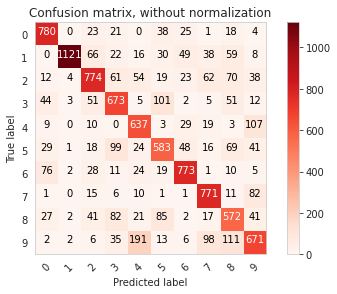

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(svc.predict(x_test),y_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')
plt.show()

In [38]:
##Logistic
l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
logistic_param = [{"penalty":["l2"], "C":C},
                  {"penalty":["l1"], "C":C},
                   {"penalty":["elasticnet"], "C":C, "l1_ratio":l1_ratio}]

logistic_classifier = GridSearchCV(LogisticRegression(solver="saga"),
                              logistic_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

logistic_classifier.fit(X,Y)
print(logistic_classifier.best_params_)
pd.DataFrame(logistic_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'C': 0.05, 'penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_l1_ratio,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
7,0.835792,0.0,0.018144,0.0,0.05,l2,NaN,"{'C': 0.05, 'penalty': 'l2'}",0.7119,0.7119,0.0,1,1.0,1.0,0.0
8,0.832969,0.0,0.018621,0.0,0.1,l2,NaN,"{'C': 0.1, 'penalty': 'l2'}",0.7109,0.7109,0.0,2,1.0,1.0,0.0
111,1.319870,0.0,0.018278,0.0,0.5,elasticnet,0.1,"{'C': 0.5, 'l1_ratio': 0.1, 'penalty': 'elasti...",0.7085,0.7085,0.0,3,1.0,1.0,0.0
120,1.365214,0.0,0.023102,0.0,1,elasticnet,0.1,"{'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticn...",0.7065,0.7065,0.0,4,1.0,1.0,0.0
27,1.256858,0.0,0.019121,0.0,10,l1,NaN,"{'C': 10, 'penalty': 'l1'}",0.7055,0.7055,0.0,5,1.0,1.0,0.0
146,1.255008,0.0,0.018381,0.0,10,elasticnet,0.9,"{'C': 10, 'l1_ratio': 0.9, 'penalty': 'elastic...",0.7054,0.7054,0.0,6,1.0,1.0,0.0
133,1.274913,0.0,0.018879,0.0,5,elasticnet,0.5,"{'C': 5, 'l1_ratio': 0.5, 'penalty': 'elasticn...",0.7053,0.7053,0.0,7,1.0,1.0,0.0
132,1.309530,0.0,0.019479,0.0,5,elasticnet,0.4,"{'C': 5, 'l1_ratio': 0.4, 'penalty': 'elasticn...",0.7052,0.7052,0.0,8,1.0,1.0,0.0
145,1.273463,0.0,0.018609,0.0,10,elasticnet,0.8,"{'C': 10, 'l1_ratio': 0.8, 'penalty': 'elastic...",0.7048,0.7048,0.0,9,1.0,1.0,0.0
131,1.336738,0.0,0.019075,0.0,5,elasticnet,0.3,"{'C': 5, 'l1_ratio': 0.3, 'penalty': 'elasticn...",0.7046,0.7046,0.0,10,1.0,1.0,0.0


In [39]:
logistic_regression = LogisticRegression(solver="saga", C = logistic_classifier.best_params_["C"], penalty=logistic_classifier.best_params_["penalty"]).fit(x_train,y_train)
print(accuracy_score(logistic_regression.predict(x_test),y_test))
print(classification_report(logistic_regression.predict(x_test),y_test))
print(confusion_matrix(logistic_regression.predict(x_test),y_test))

0.7122
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1027
           1       0.96      0.72      0.82      1507
           2       0.66      0.71      0.69       963
           3       0.70      0.67      0.69      1063
           4       0.69      0.76      0.72       895
           5       0.50      0.77      0.60       577
           6       0.84      0.76      0.80      1050
           7       0.75      0.82      0.78       944
           8       0.52      0.60      0.56       848
           9       0.62      0.55      0.58      1126

    accuracy                           0.71     10000
   macro avg       0.71      0.72      0.71     10000
weighted avg       0.73      0.71      0.72     10000

[[ 815    0   30   47    0   73   29    4   24    5]
 [   1 1086  106   24   20   64   63   33  103    7]
 [   6   39  684   51   17   12   15   60   49   30]
 [  46    2   52  711   13  131    3   10   72   23]
 [   4    0   13    2 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [40]:
#KNN 
KNN_param = {"n_neighbors":list(range(1,30,2))}

KNN_classifier = GridSearchCV(KNeighborsClassifier(),
                              KNN_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

KNN_classifier.fit(X,Y)
print(KNN_classifier.best_params_)
pd.DataFrame(KNN_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'n_neighbors': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,0.011281,0.0,1.959740,0.0,1,{'n_neighbors': 1},0.6589,0.6589,0.0,1,1.00,1.00,0.0
1,0.010449,0.0,1.976454,0.0,3,{'n_neighbors': 3},0.6088,0.6088,0.0,2,0.74,0.74,0.0
2,0.010603,0.0,1.999638,0.0,5,{'n_neighbors': 5},0.6010,0.6010,0.0,3,0.69,0.69,0.0
3,0.013268,0.0,2.000703,0.0,7,{'n_neighbors': 7},0.5708,0.5708,0.0,4,0.64,0.64,0.0
4,0.010513,0.0,1.952719,0.0,9,{'n_neighbors': 9},0.5549,0.5549,0.0,5,0.61,0.61,0.0
5,0.013021,0.0,1.969771,0.0,11,{'n_neighbors': 11},0.5378,0.5378,0.0,6,0.59,0.59,0.0
6,0.010341,0.0,1.962501,0.0,13,{'n_neighbors': 13},0.5218,0.5218,0.0,7,0.60,0.60,0.0
7,0.010472,0.0,1.959569,0.0,15,{'n_neighbors': 15},0.5037,0.5037,0.0,8,0.63,0.63,0.0
8,0.010235,0.0,1.973891,0.0,17,{'n_neighbors': 17},0.4912,0.4912,0.0,9,0.58,0.58,0.0
9,0.010789,0.0,1.973162,0.0,19,{'n_neighbors': 19},0.4724,0.4724,0.0,10,0.60,0.60,0.0


In [41]:
KNN = KNeighborsClassifier(n_neighbors=KNN_classifier.best_params_["n_neighbors"]).fit(x_train,y_train)
print(accuracy_score(KNN.predict(x_test),y_test))
print(classification_report(KNN.predict(x_test),y_test))
print(confusion_matrix(KNN.predict(x_test),y_test))

0.6589
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       945
           1       0.99      0.61      0.75      1865
           2       0.42      0.75      0.54       583
           3       0.56      0.65      0.60       869
           4       0.61      0.63      0.62       951
           5       0.58      0.59      0.59       877
           6       0.79      0.84      0.82       894
           7       0.76      0.72      0.74      1096
           8       0.47      0.59      0.52       765
           9       0.58      0.51      0.54      1155

    accuracy                           0.66     10000
   macro avg       0.65      0.67      0.65     10000
weighted avg       0.70      0.66      0.67     10000

[[ 760    0   46   45    1   33   31    0   21    8]
 [   5 1129  265   48   51   72   80   58  134   23]
 [   1    0  438   14   28    7    0   36   52    7]
 [  31    2   47  566    5  100    1   13   88   16]
 [  36    0   38    2 